# Overview

The objective of the ["Predict the Introverts from the Extroverts"](https://www.kaggle.com/competitions/playground-series-s5e7/) competition (one of Kaggle's playground series) is to, given a synthetically-generated dataset of people with corresponding IDs and various characteristics recorded, predict whether a person is an introvert or an extrovert.

# Setup

Let's first do some initial setup to import what we'll need, and set some configurations that will make it easier to check the output.

In [1]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

pd.set_option('display.max_colwidth', None) # Display full column content
pd.set_option('display.width', 1000) # Set larger display width

Now, let's read the data, and set some variables that we'll use later on.

In [2]:
# Read data files
input_filepath = '/kaggle/input'
train_data = pd.read_csv(input_filepath + '/playground-series-s5e7/train.csv')
test_data = pd.read_csv(input_filepath + '/playground-series-s5e7/test.csv')

# Get numeric and categorical columns of training data
train_numeric_col_names = train_data.select_dtypes(include='number').columns.to_series()
train_categorical_col_names = train_data.select_dtypes(include='object').columns.to_series()
assert train_numeric_col_names.size + train_categorical_col_names.size == train_data.shape[1]

# Set target column
target_col='Personality'
# Drop id column from numeric column names
train_numeric_col_names.drop('id', inplace=True)
# Drop personality column from categorical column names
train_categorical_col_names.drop(target_col, inplace=True)

# Set an arbitrary value that can be used to specify the random_state later
random_state = 11

It will be helpful to first get a basic idea of how many rows and columns are in the dataset, and whether there are any missing data.

In [3]:
def print_basic_info(dataset_name, dataset):
    print('\n' + dataset_name + ' shape:', dataset.shape)
    print(dataset_name + ' missing values:')
    print(dataset.isnull().sum())

# Take a look at training dataset
print_basic_info('Training dataset', train_data)
# Take a look at test dataset
print_basic_info('Test dataset', test_data)


Training dataset shape: (18524, 9)
Training dataset missing values:
id                              0
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

Test dataset shape: (6175, 8)
Test dataset missing values:
id                             0
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64


Both the training and test datasets are not large, and there are indeed some missing values in each.<br>
The missing values will have to be handled in the data preprocessing stage later.

# Examining the data

Let's examine the data more closely with the help of some charts.

It appears there is almost three times more data on extroverts than there is data on introverts.<br>
The Synthetic Minority Oversampling Technique (like
[SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html) from [imblearn](https://imbalanced-learn.org/)) is one way to try addressing class imbalance issues, but perhaps it's not necessary to do so as the imbalance is not that extreme.

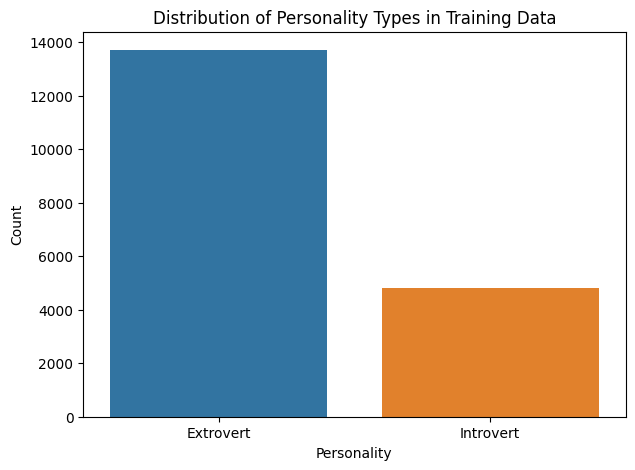

In [4]:
# See the distribution of personality types in the training data
plt.figure(figsize=(7, 5))
sns.countplot(x='Personality', data=train_data)
plt.title('Distribution of Personality Types in Training Data')
plt.xlabel('Personality')
plt.ylabel('Count')
plt.show()

The following kernel density estimate plots show that for all the numeric columns in the training dataset, apart from the 'friends circle size' column, it appears there is not a significant overlap in the distribution of data when categorizing the data based on personality (i.e. extrovert or introvert).

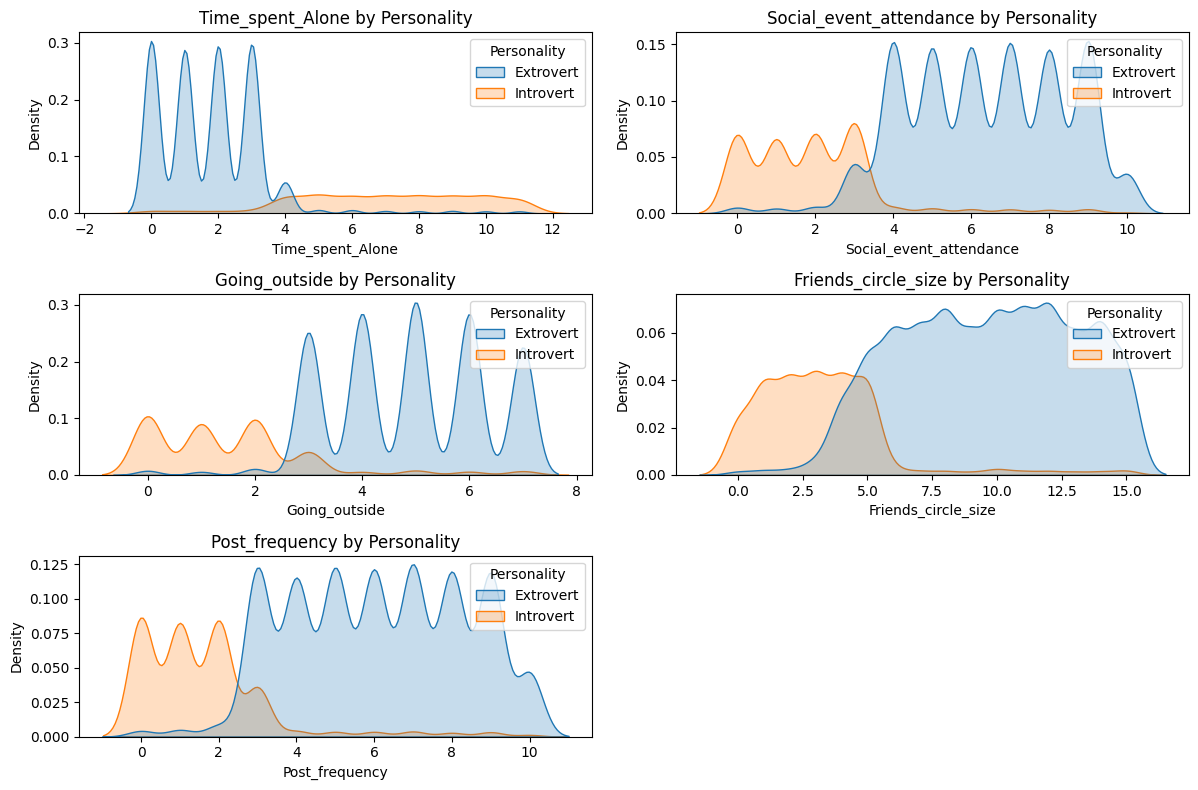

In [5]:
# KDE plots of numerical features with target variable as hue
plt.figure(figsize=(12, 8))
for i, col in enumerate(train_numeric_col_names, start=1):
    plt.subplot(3, 2, i)
    sns.kdeplot(data=train_data, x=col, hue='Personality', shade=True)
    plt.tight_layout()
    plt.title(f'{col} by Personality')

A correlation matrix of the numerical features seems to indicate that there are no highly-correlated features.

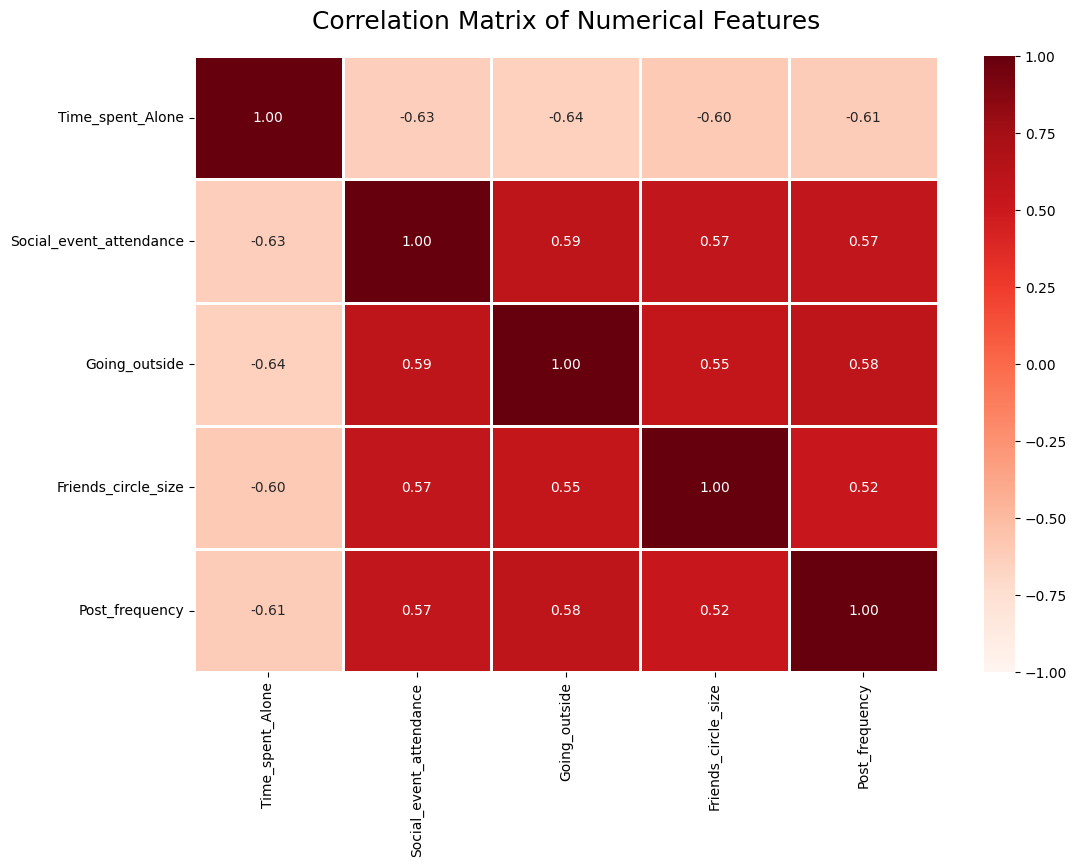

In [6]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    train_data[train_numeric_col_names].corr(),
    cmap='Reds',
    annot=True,
    linewidths=2,
    fmt='.2f',
    vmin=-1,
    vmax=1
)
plt.title('Correlation Matrix of Numerical Features', fontsize=18, pad=20)
plt.show()

A crosstabulation of the categorical features shows that a majority (over 96%) of the data is consistent with what one would generally expect to be the typical response from introverts and extroverts. For example, whereas extroverts are not as likely to report having stage fear or being drained after socializing, introverts are more likely to do so.

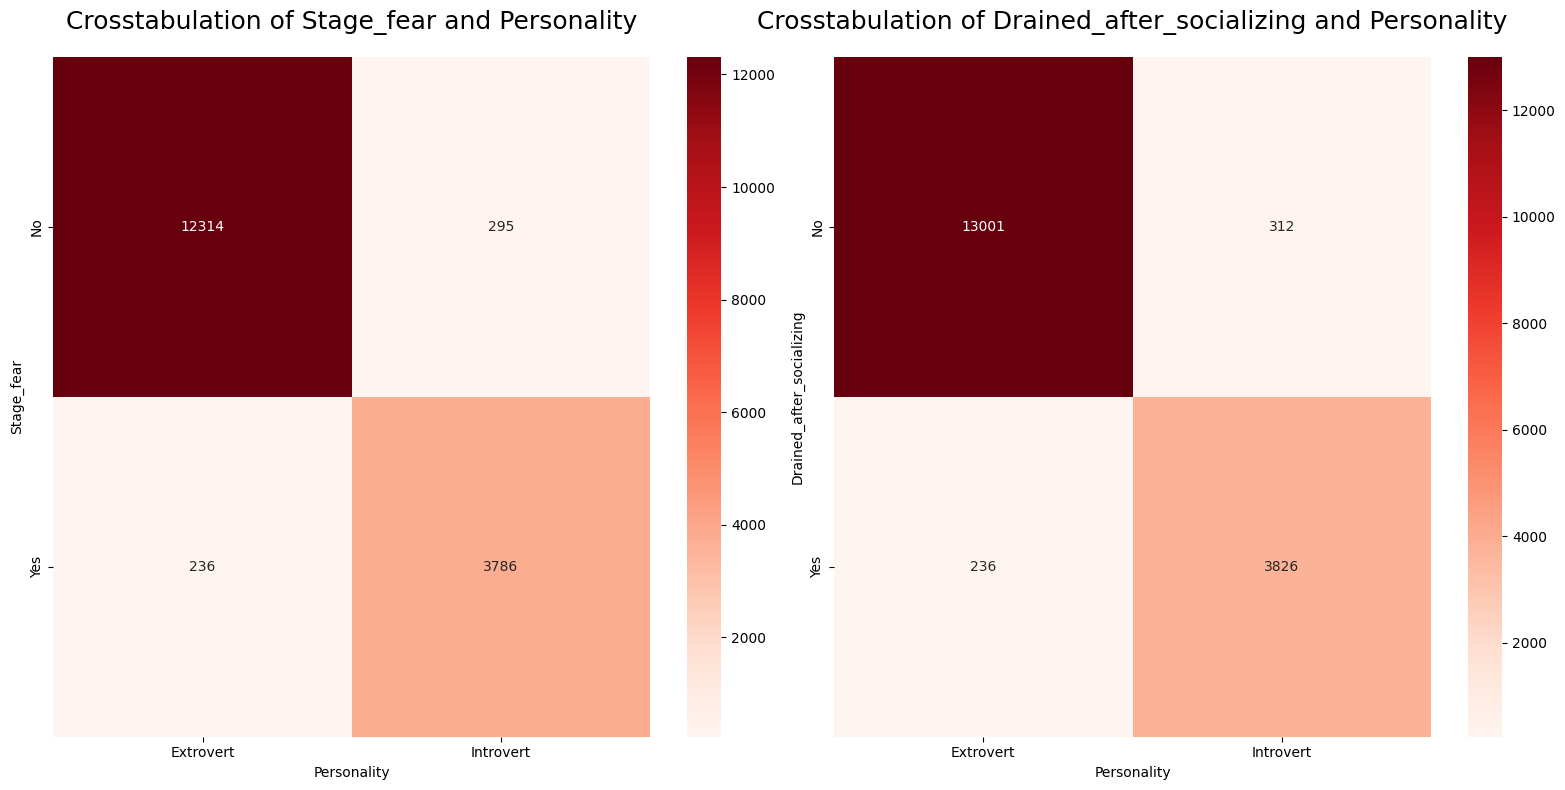

In [7]:
# Crosstabulation of categorical features with target variable
plt.figure(figsize=(16, 8))
for i, col in enumerate(train_categorical_col_names, start=1):
    plt.subplot(1, 2, i)
    crosstab = pd.crosstab(train_data[col], train_data['Personality'])
    sns.heatmap(crosstab, cmap='Reds', annot=True, fmt='d')
    plt.tight_layout()
    plt.title(f'Crosstabulation of {col} and Personality', fontsize=18, pad=20)

# Data Preprocessing

In the data preprocessing stage, we'll prepare the data for training, including handling processing to try address some of the issues that were identified earlier.

We'll use a cross-validation function ([GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)) provided by the [scikit-learn](https://scikit-learn.org/) library for training later, so all rows of the dataset retrieved from the train.csv file will be used for:
- `X_train`: the input data (features) used for training
- `y_train`: the target values corresponding to `X_train`

Likewise, all rows retrieved from the test.csv file will be used for:
- `X_test`: the input data (features) used for making predictions about the target values for the test dataset

For model training, we'll also have to encode the categorical features and the target variable, and handle the missing values in the data. Missing data for
- categorical features will be imputed using scikit-learn's [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html), where the most frequent value found in each respective column is used as a replacement for the missing values,
- and numerical features can also be imputed using SimpleImputer, but scikit-learn's [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) (which imputes by using a mean value from a specified number of nearest neighbors found in the dataset) is used instead as it may allow for more accurate results.

In [8]:
# Prepare dataframes that will be used for training and prediction
X_train = train_data.drop(['id', target_col], axis=1)
y_train = train_data[target_col]
X_test = test_data.drop(['id'], axis=1)

# Encode target variable
lbl_encoder = LabelEncoder()
y_train = pd.Series(lbl_encoder.fit_transform(y_train))
print(f"Label encoding complete with class labels: {lbl_encoder.classes_}\n")

# Handle missing values for numeric features: impute using k-nearest neighbors
numeric_imputer = KNNImputer(weights='distance')
X_train[train_numeric_col_names] = numeric_imputer.fit_transform(X_train[train_numeric_col_names])
X_test[train_numeric_col_names] = numeric_imputer.fit_transform(X_test[train_numeric_col_names])

# Handle missing values for categorical features: impute with mode
categorical_imputer = SimpleImputer(strategy='most_frequent')
X_train[train_categorical_col_names] = categorical_imputer.fit_transform(X_train[train_categorical_col_names])
X_test[train_categorical_col_names] = categorical_imputer.fit_transform(X_test[train_categorical_col_names])

# Encode categorical features
X_train = pd.get_dummies(
    X_train,
    columns=train_categorical_col_names,
    drop_first=True,
    dtype=int
)
X_test = pd.get_dummies(
    X_test,
    columns=train_categorical_col_names,
    drop_first=True,
    dtype=int
)

Label encoding complete with class labels: ['Extrovert' 'Introvert']



## Feature Generation

To try to capture more of the complex relationships between features in our model that we'll train, new features will be created by applying some transformations to existing features.

As it seems that two good indicators of whether a person is an extrovert (or conversely, an introvert) is how comfortable they feel with socializing and how often they go outside, 'social comfort' and 'outside exposure' features are added to our datasets.
- Social comfort is approximated by adding the average of features that would be positively correlated with the degree to which a person is sociable ('social event attendance', 'friends circle size', 'post frequency'), and subtracting the product of a multiplier with the average of features that would be negatively correlated with the degree to which a person is sociable ('stage fear', 'drained after socializing'). As the negatively correlated features chosen are all categorical and encoded into 0s and 1s, it would not be a fair comparison between them and the positively-correlated features, so the multiplier (the median of the positively correlated features) is used to try to make the comparison one that is more fair.
- Outside exposure is approximated by taking the average of two features that indicate or imply that one goes outside ('going outside', 'social_event_attendance'), and subtracting a feature that would be negatively correlated with going outside ('time spent alone'). In retrospect, time may be spent alone outside as well, so there seems to be room for improvement regarding the generation of this feature.

In [9]:
# Feature generation
social_index_train = (X_train['Social_event_attendance'] + X_train['Friends_circle_size'] + X_train['Post_frequency']) / 3
social_index_test = (X_test['Social_event_attendance'] + X_test['Friends_circle_size'] + X_test['Post_frequency']) / 3
social_discomfort_index_train = (X_train['Stage_fear_Yes'] + X_train['Drained_after_socializing_Yes']) / 2
social_discomfort_index_test = (X_test['Stage_fear_Yes'] + X_test['Drained_after_socializing_Yes']) / 2
X_train['Social_comfort'] = social_index_train - (social_discomfort_index_train * social_index_train.median())
X_test['Social_comfort'] = social_index_test - (social_discomfort_index_test * social_index_test.median())
X_train['Outside_exposure'] = ((X_train['Going_outside'] + X_train['Social_event_attendance']) / 2) - X_train['Time_spent_Alone']
X_test['Outside_exposure'] = ((X_test['Going_outside'] + X_test['Social_event_attendance']) / 2) - X_test['Time_spent_Alone']

# Add the new generated features to train_numeric_col_names
new_numeric_col_names = pd.Series(['Social_comfort', 'Outside_exposure'])
train_numeric_col_names = pd.concat([train_numeric_col_names, new_numeric_col_names], ignore_index=True)

## Capping Outliers

To prevent any skewing from outliers, outliers will not be removed, but they will be capped so all values do not exceed a lower and upper threshold for both the training and test datasets. Applying a multiplier (like 1.5) to the interquartile range, and subtracting and adding the result to the first and third quantiles, respectively, is a common approach, and one that will be taken here.

From the dataframe shown in the output below, we can see that apart from the 'time spent alone' feature that had 1692 values trimmed for the training dataset and 546 for the test dataset, all the numerical features do not appear to have any significant outliers.

In [10]:
# Cap outliers
num_values_trimmed = []
for col in train_numeric_col_names:
    first_quartile = X_train[col].quantile(0.25)
    third_quartile = X_train[col].quantile(0.75)
    interquartile_range = third_quartile - first_quartile
    multiplier = 1.5
    lower_threshold = first_quartile - multiplier * interquartile_range
    upper_threshold = third_quartile + multiplier * interquartile_range
    num_values_trimmed.append({
        'Column': col,
        '# values to be trimmed (train_data)': sum(1 for x in X_train[col] if (x < lower_threshold or x > upper_threshold)),
        '# values to be trimmed (test_data)': sum(1 for x in X_test[col] if (x < lower_threshold or x > upper_threshold)),
        '(min, first_quartile, third_quartile, max)': f'({min(X_train[col]):.1f}, {first_quartile:.1f}, {third_quartile:.1f}, {max(X_train[col]):.1f})',
        '(lower_threshold, upper_threshold)': f'({lower_threshold:.1f}, {upper_threshold:.1f})'
    })
    X_train[col].clip(lower=lower_threshold, upper=upper_threshold, inplace=True)
    X_test[col].clip(lower=lower_threshold, upper=upper_threshold, inplace=True)
pd.DataFrame(num_values_trimmed)

,Column,# values to be trimmed (train_data),# values to be trimmed (test_data),"(min, first_quartile, third_quartile, max)","(lower_threshold, upper_threshold)"
0,Time_spent_Alone,1692,546,"(0.0, 1.0, 4.0, 11.0)","(-3.5, 8.5)"
1,Social_event_attendance,0,0,"(0.0, 3.0, 7.2, 10.0)","(-3.3, 13.5)"
2,Going_outside,0,0,"(0.0, 3.0, 6.0, 7.0)","(-1.5, 10.5)"
3,Friends_circle_size,0,0,"(0.0, 5.0, 11.2, 15.0)","(-4.3, 20.5)"
4,Post_frequency,0,0,"(0.0, 3.0, 7.0, 10.0)","(-3.0, 13.0)"
5,Social_comfort,0,0,"(-6.8, -0.4, 8.1, 11.7)","(-13.2, 20.9)"
6,Outside_exposure,0,0,"(-11.0, -2.0, 5.0, 8.5)","(-12.5, 15.5)"


## Scaling Features

As some of the models that we will be using require the features to be scaled to obtain more meaningful results, scaled versions of `X_train` and `X_test` are prepared.

In [11]:
# Prepare dataframes of scaled features
std_scaler = StandardScaler()
X_train_scaled = pd.DataFrame(std_scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(std_scaler.transform(X_test), columns=X_test.columns)

# Feature Importance

Having completed data preprocessing, let's take a look at how important each feature is in predicting personality using a random forest.

It seems the two features generated earlier ('social comfort' and 'outside exposure') are ranked the highest in terms of importance.

In [12]:
# Take a look at feature importance using Random Forest
rf_classifier = RandomForestClassifier(
    n_estimators=200,
    random_state=random_state
)
rf_classifier.fit(X_train, y_train)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_classifier.feature_importances_
})
feature_importance.sort_values(by='Importance', ascending=False)

,Feature,Importance
7,Social_comfort,0.318081
8,Outside_exposure,0.270565
2,Going_outside,0.113653
4,Post_frequency,0.102973
1,Social_event_attendance,0.078243
0,Time_spent_Alone,0.054419
6,Drained_after_socializing_Yes,0.027611
3,Friends_circle_size,0.024981
5,Stage_fear_Yes,0.009475


# Model Selection

To choose a model which we'll use to make predictions:
- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) will be used to perform an exhaustive search over various parameter values specified for a model to find the combination of parameters that result in the model's best performance.
- An array of models which we are interested in (along with corresponding parameter values) will be passed to GridSearchCV so that a comparison between the models' performance can be made.

First, let's specify the models (which GridSearchCV refers to as estimators) and the parameter values that we want GridSearchCV to perform a cross-validated parameter grid-search over.

In [13]:
# Define the estimators that will be passed to GridSearchCV for hyperparameter tuning
# Note that the values for the parameter grid have already been adjusted after several iterations
estimator_key = 'estimator'
param_grid_key = 'param_grid'
use_scaled_features_key = 'use_scaled_features'
grid_search_cv_estimators = {
    'logistic_reg': {
        estimator_key: LogisticRegression(random_state=random_state),
        param_grid_key: {
            'C': [0.0001, 0.001, 0.1],
            'solver': ['liblinear', 'lbfgs', 'newton-cg', 'newton-cholesky'],
            'max_iter': list(range(25, 200, 25))
        },
        use_scaled_features_key: True
    },
    'random_forest': {
        estimator_key: RandomForestClassifier(random_state=random_state),
        param_grid_key: {
            'n_estimators': list(range(150, 350, 25)),
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': list(range(1, 3, 1)),
        },
        use_scaled_features_key: False
    },
    'gradient_boost': {
        estimator_key: GradientBoostingClassifier(random_state=random_state),
        param_grid_key: {
            'learning_rate': [0.01, 0.1],
            'n_estimators': list(range(150, 250, 25)),
            'max_depth': list(range(1, 3, 1))
        },
        use_scaled_features_key: False
    },
    'xgb': {
        estimator_key: XGBClassifier(random_state=random_state, eval_metric=['logloss']),
        param_grid_key: {
            'learning_rate': [0.01, 0.1],
            'n_estimators': list(range(150, 450, 25)),
            'max_depth': list(range(2, 4, 1))
        },
        use_scaled_features_key: False
    },
    'k-neighbors': {
        estimator_key: KNeighborsClassifier(),
        param_grid_key: {
            'n_neighbors': list(range(6, 8, 1)),
            'weights': ['uniform', 'distance']
        },
        use_scaled_features_key: True
    },
    'support_vector': {
        estimator_key: SVC(probability=True, class_weight='balanced', random_state=random_state),
        param_grid_key: {
            'C': [0.01, 0.1],
            'kernel': ['linear', 'rbf', 'sigmoid'],
            'gamma': ['scale', 'auto']
        },
        use_scaled_features_key: True
    }
}

Next, the models and corresponding parameter grids are passed to GridSearchCV for the search, using weighted F1 scores as the metric to determine model performance as class imbalance was found in the training dataset.

The outputted dataframe indicates that the xgb model obtained the highest score with the following parameters that were included in the parameter grid-search:
- learning_rate: 0.1
- max_depth: 3
- n_estimators: 225

In [14]:
# Perform hyperparameter tuning using GridSearchCV
results = []
for estimator_name, estimator in grid_search_cv_estimators.items():
    print(f'Executing GridSearchCV for {estimator_name}..')
    gscv = GridSearchCV(
        estimator[estimator_key],
        estimator[param_grid_key],
        n_jobs=-1,
        scoring='f1_weighted'
    )
    X_to_train_on = X_train_scaled if estimator[use_scaled_features_key] else X_train
    gscv.fit(X_to_train_on, y_train)
    results.append({
        'estimator': estimator_name,
        'best_score': gscv.best_score_,
        'best_params': gscv.best_params_
    })
results = pd.DataFrame(results).sort_values(by='best_score', ascending=False)
results

Executing GridSearchCV for logistic_reg..
Executing GridSearchCV for random_forest..
Executing GridSearchCV for gradient_boost..
Executing GridSearchCV for xgb..
Executing GridSearchCV for k-neighbors..
Executing GridSearchCV for support_vector..


,estimator,best_score,best_params
3,xgb,0.969179,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 225}"
2,gradient_boost,0.968907,"{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 225}"
0,logistic_reg,0.968852,"{'C': 0.1, 'max_iter': 25, 'solver': 'liblinear'}"
1,random_forest,0.968755,"{'criterion': 'gini', 'max_depth': 1, 'n_estimators': 325}"
5,support_vector,0.968706,"{'C': 0.01, 'gamma': 'scale', 'kernel': 'rbf'}"
4,k-neighbors,0.968365,"{'n_neighbors': 7, 'weights': 'uniform'}"


# Model Training

Since xgb attained the highest cross-validation score (although not by a wide margin compared with the other models), let's train a xgb model on the training data using the 'best parameters' found by GridSearchCV.

In [15]:
# Pick XGBoost which got the best score, and use the parameters found from GridSearchCV
xgb_params = results[results['estimator']=='xgb']['best_params'].iloc[0]
xgb_classifier = XGBClassifier(
    n_estimators=xgb_params['n_estimators'],
    max_depth=xgb_params['max_depth'],
    learning_rate=xgb_params['learning_rate'],
    n_jobs=-1,
    random_state=random_state
)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=225, n_jobs=-1,
              num_parallel_tree=None, random_state=11, ...)

# Prediction and Submission

Using the xgb model trained, we'll make predictions on the test data, and convert the values back to the format that is required for submission to the competition.

In [16]:
# Get predictions of target variable
y_preds = xgb_classifier.predict(X_test)
# Convert predictions from '0's and '1's back to 'Extrovert' and 'Introvert'
preds = ['Introvert' if is_introvert else 'Extrovert' for is_introvert in y_preds]
# Prepare submission
submission = pd.DataFrame({'id': test_data['id'], 'Personality': preds})
submission.to_csv('submission.csv', index=False)

# Retrospective

- As the model selected for training, xgb, is quite robust to outliers, the step of capping outliers may not have had much of an effect on the prediction results, which I also observed in the cross-validation scores from GridSearchCV when temporarily omitting the step to cap the outliers to see the effect it had on the scores.
- I was wary from the start of overfitting to the public leaderboard, taking care to not focus my efforts on doing a too fine-grained grid-search of the parameters for each model. The results from the private leaderboard (announced after the competition was over) indicated that my rank was more than 300 lower than my rank on the public leaderboard, although the difference in score between the two leaderboards was only $0.974898-0.968421=0.006477$, so perhaps other factors may have been more significant in explaining the drop in ranking.